In [12]:
# question 5


import random
import math
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image, ImageOps


def idx_to_rc(idx: int, W: int) -> Tuple[int,int]:
    return divmod(idx, W)  # (r, c)

def rc_to_idx(r: int, c: int, W: int) -> int:
    return r * W + c

# ---------------------------
# (a) Edge extraction & pairwise compatibility
# ---------------------------
def img_to_array(img: Image.Image) -> np.ndarray:
    return np.asarray(img.convert("RGB"), dtype=np.float32)

def extract_edges(arr: np.ndarray) -> Dict[str, np.ndarray]:
    # arr.shape = (s, s, 3)
    s = arr.shape[0]
    return {
        "top": arr[0, :, :].copy(),        # row 0 (left->right)
        "bottom": arr[s-1, :, :].copy(),   # row s-1
        "left": arr[:, 0, :].copy(),       # col 0 (top->bottom)
        "right": arr[:, s-1, :].copy()     # col s-1
    }

def edge_distance(edge_a: np.ndarray, edge_b: np.ndarray) -> float:
    diff = edge_a - edge_b
    ssd = np.sum(diff * diff)  # sum squared diff across RGB and pixels
    return float(ssd)

def precompute_compatibilities(pieces: List[Image.Image], blur: bool=False) -> Dict[Tuple[int,int,str], float]:
    """
    Returns a dict compat[(i,j,dir)] giving compatibility score when piece i is adjacent
    to piece j in direction dir, where dir is one of 'right' or 'bottom'.
    For 'right', we compare i.right with j.left.
    For 'bottom', compare i.bottom with j.top.
    """
    n = len(pieces)
    arrays = [img_to_array(p) for p in pieces]
    edges = [extract_edges(a) for a in arrays]

    # compute raw distances (lower better) then convert to compatibility (higher better)
    raw = {}
    for i in range(n):
        for j in range(n):
            if i == j:
                raw[(i,j,'right')] = 1e9
                raw[(i,j,'bottom')] = 1e9
                continue
            d_right = edge_distance(edges[i]['right'], edges[j]['left'])
            d_bottom = edge_distance(edges[i]['bottom'], edges[j]['top'])
            raw[(i,j,'right')] = d_right
            raw[(i,j,'bottom')] = d_bottom

    vals = np.array([v for k,v in raw.items() if v < 1e8])
    med = np.median(vals) if len(vals)>0 else 1.0
    lam = 1.0 / (med + 1e-8)

    compat = {}
    for k, d in raw.items():
        if d > 1e8:
            compat[k] = 0.0
        else:
            compat[k] = math.exp(-lam * d)
    return compat

# ---------------------------
# (b) Fitness evaluation
# ---------------------------
def fitness_of_perm(perm: List[int], compat: Dict[Tuple[int,int,str], float], H: int, W: int) -> float:
    """
    Compute total adjacency compatibility for a full assignment 'perm' of length H*W.
    perm[idx] = piece index placed at cell idx.
    """
    total = 0.0
    n = H * W
    for idx in range(n):
        r, c = idx_to_rc(idx, W)
        a = perm[idx]
        # right neighbor
        if c < W - 1:
            b = perm[rc_to_idx(r, c+1, W)]
            total += compat.get((a,b,'right'), 0.0)
        # bottom neighbor
        if r < H - 1:
            b = perm[rc_to_idx(r+1, c, W)]
            total += compat.get((a,b,'bottom'), 0.0)
    return total

# ---------------------------
# GA operators: OX crossover, swap mutation
# ---------------------------
def order_crossover(parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
    """Order Crossover (OX) for permutations."""
    n = len(parent1)
    c1, c2 = [-1]*n, [-1]*n
    a = random.randint(0, n-2)
    b = random.randint(a+1, n-1)
    # Copy slice
    c1[a:b+1] = parent1[a:b+1]
    c2[a:b+1] = parent2[a:b+1]
    # Fill remaining from other parent in order
    def fill(child, donor):
        n = len(child)
        cur = (b+1) % n
        di = (b+1) % n
        while -1 in child:
            if donor[di] not in child:
                child[cur] = donor[di]
                cur = (cur + 1) % n
            di = (di + 1) % n
        return child
    return fill(c1, parent2), fill(c2, parent1)

def swap_mutation(perm: List[int], prob: float=0.1) -> None:
    if random.random() < prob:
        i = random.randrange(len(perm))
        j = random.randrange(len(perm))
        perm[i], perm[j] = perm[j], perm[i]

# ---------------------------
# Selection: tournament
# ---------------------------
def tournament_select(pop: List[List[int]], fitnesses: List[float], k: int=3) -> List[int]:
    best = None
    best_f = -1e18
    n = len(pop)
    for _ in range(k):
        idx = random.randrange(n)
        if fitnesses[idx] > best_f:
            best_f = fitnesses[idx]
            best = pop[idx]
    return best.copy()

# ---------------------------
# Full GA loop
# ---------------------------
def run_ga(pieces: List[Image.Image], H: int, W: int,
           pop_size: int=200, generations: int=1000, elite: int=2,
           crossover_prob: float=0.9, mutation_prob: float=0.2,
           tournament_k: int=3, seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    n = H * W
    assert len(pieces) == n, "Number of pieces must equal H*W"

    compat = precompute_compatibilities(pieces)
    # initialize population: random permutations
    population = [random.sample(range(n), n) for _ in range(pop_size)]
    fitnesses = [fitness_of_perm(ind, compat, H, W) for ind in population]

    best = None
    best_f = -1e18
    stagn = 0
    for gen in range(generations):
        # sort population by fitness descending
        zipped = list(zip(population, fitnesses))
        zipped.sort(key=lambda x: x[1], reverse=True)
        population, fitnesses = zip(*zipped)
        population = [p.copy() for p in population]
        fitnesses = list(fitnesses)

        # keep elites
        new_pop = population[:elite]
        new_fit = fitnesses[:elite]

        # track best
        if fitnesses[0] > best_f:
            best_f = fitnesses[0]
            best = population[0].copy()
            stagn = 0
        else:
            stagn += 1

        # produce offspring
        while len(new_pop) < pop_size:
            # select parents
            p1 = tournament_select(population, fitnesses, tournament_k)
            p2 = tournament_select(population, fitnesses, tournament_k)
            # crossover
            if random.random() < crossover_prob:
                c1, c2 = order_crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            # mutation
            swap_mutation(c1, mutation_prob)
            swap_mutation(c2, mutation_prob)
            # evaluate
            f1 = fitness_of_perm(c1, compat, H, W)
            new_pop.append(c1); new_fit.append(f1)
            if len(new_pop) < pop_size:
                f2 = fitness_of_perm(c2, compat, H, W)
                new_pop.append(c2); new_fit.append(f2)

        population = new_pop
        fitnesses = new_fit

        # optional: print progress
        if gen % 50 == 0 or gen == generations-1:
            print(f"Gen {gen:4d}  best_f={best_f:.6f}  avg={np.mean(fitnesses):.6f}  stagn={stagn}")

        # optional early stop
        if stagn > 300:
            print("No improvement for many generations — stopping early.")
            break

    # return best arrangement and its fitness
    return best, best_f, compat

# ---------------------------
# Helpers to render arrangement
# ---------------------------
def render_arrangement(perm: List[int], pieces: List[Image.Image], H: int, W: int) -> Image.Image:
    s = pieces[0].size[0]
    canvas = Image.new("RGB", (W*s, H*s))
    for idx, pidx in enumerate(perm):
        r, c = idx_to_rc(idx, W)
        canvas.paste(pieces[pidx], (c*s, r*s))
    return canvas

# ---------------------------
# Example usage:
# ---------------------------
if __name__ == "__main__":
    # Load piece images named "piece_0.png", "piece_1.png", ... and set H,W
    import glob, os
    piece_files = sorted(glob.glob("pieces/*.png"))
    pieces = [Image.open(f) for f in piece_files]
    H = 3  # set your grid size
    W = 3
    best_perm, best_f, compat = run_ga(pieces, H, W, pop_size=200, generations=1000)
    print("Best fitness:", best_f)
    out = render_arrangement(best_perm, pieces, H, W)
    out.save("assembled_best.png")
    print("Saved assembled_best.png")


AssertionError: Number of pieces must equal H*W

Swap neighbour: {'mean_length': np.float64(6.786309869359981), 'std_length': np.float64(0.44883861012031795), 'min_length': np.float64(6.49377991231187), 'mean_runtime': np.float64(1.7172656536102295), 'std_runtime': np.float64(0.10477945199033803), 'mean_evals': np.float64(100000.0), 'std_evals': np.float64(0.0), 'all_lengths': array([7.65999427, 6.49377991, 6.76733364, 6.50522076, 6.50522076]), 'all_runtimes': array([1.68118095, 1.65271139, 1.91929317, 1.70822096, 1.6249218 ]), 'all_evals': array([100000, 100000, 100000, 100000, 100000])}
2-opt neighbour: {'mean_length': np.float64(6.786309869359981), 'std_length': np.float64(0.44883861012031795), 'min_length': np.float64(6.49377991231187), 'mean_runtime': np.float64(1.815385103225708), 'std_runtime': np.float64(0.10290321976356397), 'mean_evals': np.float64(100000.0), 'std_evals': np.float64(0.0), 'all_lengths': array([7.65999427, 6.49377991, 6.76733364, 6.50522076, 6.50522076]), 'all_runtimes': array([1.87485266, 1.96865582, 1.8294

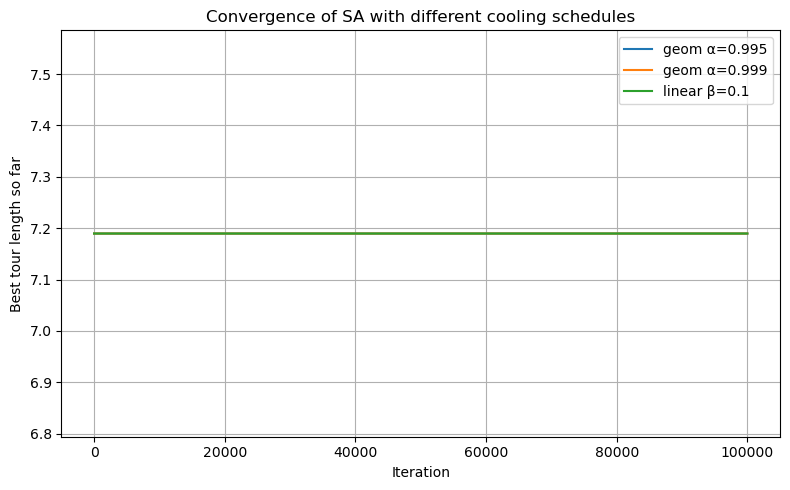

Random initialisation: {'mean_length': np.float64(19.20942552618249), 'std_length': np.float64(0.42332296943305164), 'min_length': np.float64(18.51078792990981), 'mean_runtime': np.float64(1.7254833698272705), 'std_runtime': np.float64(0.04725723472404587), 'mean_evals': np.float64(100000.0), 'std_evals': np.float64(0.0), 'all_lengths': array([19.82292881, 19.25918287, 19.10788869, 19.34633934, 18.51078793]), 'all_runtimes': array([1.76845574, 1.70090055, 1.7796936 , 1.72881413, 1.64955282]), 'all_evals': array([100000, 100000, 100000, 100000, 100000])}
Greedy NN initialisation: {'mean_length': np.float64(6.786309869359981), 'std_length': np.float64(0.44883861012031795), 'min_length': np.float64(6.49377991231187), 'mean_runtime': np.float64(1.7338377952575683), 'std_runtime': np.float64(0.04184648952253483), 'mean_evals': np.float64(100000.0), 'std_evals': np.float64(0.0), 'all_lengths': array([7.65999427, 6.49377991, 6.76733364, 6.50522076, 6.50522076]), 'all_runtimes': array([1.67676

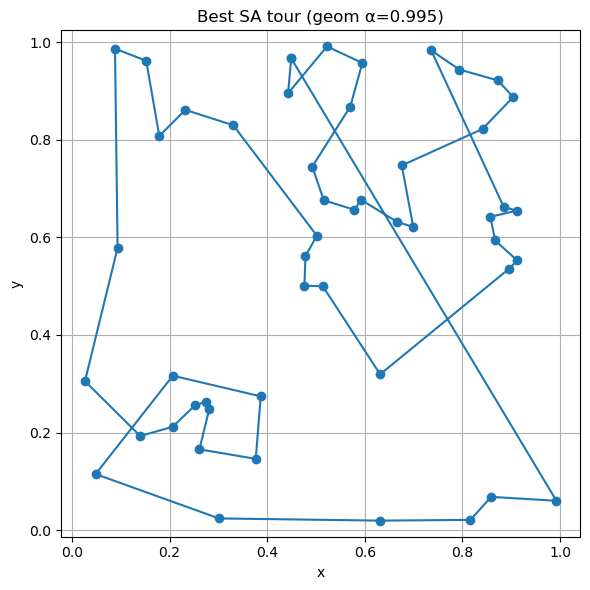

Sensitivity to T0 (geometric α=0.995):
T0=  10.0 -> mean length = 6.974 ± 0.498
T0=  50.0 -> mean length = 6.974 ± 0.498
T0= 100.0 -> mean length = 6.974 ± 0.498
T0= 500.0 -> mean length = 6.974 ± 0.498

------------------------------------------------------------

Sensitivity to α (geometric cooling):
α= 0.950 -> mean length = 5.813 ± 0.117
α= 0.990 -> mean length = 6.974 ± 0.498
α= 0.995 -> mean length = 6.974 ± 0.498
α= 0.999 -> mean length = 6.974 ± 0.498

------------------------------------------------------------

Sensitivity to iterations per temperature (M):
M=  250 -> mean length = 6.974 ± 0.498
M=  500 -> mean length = 6.974 ± 0.498
M= 1000 -> mean length = 6.974 ± 0.498
Greedy NN baseline tour length: 7.1896263883591836
Best SA (geom α=0.995) tour length: 7.1896263883591836


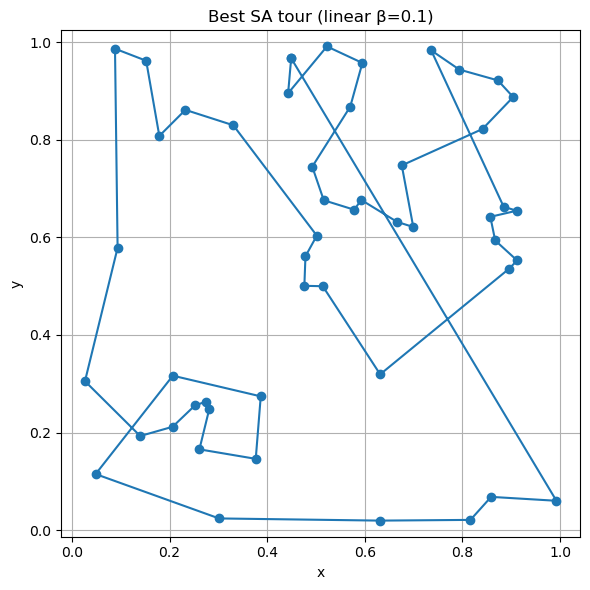

In [9]:
# question 6
import numpy as np
import math
import time
import random
from typing import Callable, Dict, Any, List, Tuple

#tsp
def compute_distance_matrix(coords: np.ndarray) -> np.ndarray:
    N = coords.shape[0]
    dist = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(N):
            dx = coords[i, 0] - coords[j, 0]
            dy = coords[i, 1] - coords[j, 1]
            dist[i, j] = math.hypot(dx, dy)
    return dist

def tour_length(tour: np.ndarray, dist: np.ndarray) -> float:
    N = len(tour)
    total = 0.0
    for k in range(N):
        i = tour[k]
        j = tour[(k + 1) % N]  # wrap to start
        total += dist[i, j]
    return total

def init_random(N: int, rng: random.Random) -> np.ndarray:
    tour = list(range(N))
    rng.shuffle(tour)
    return np.array(tour, dtype=int)


def init_nearest_neighbour(dist: np.ndarray, rng: random.Random,
                           start_city: int = None) -> np.ndarray:
    N = dist.shape[0]
    if start_city is None:
        start_city = rng.randrange(N)

    unvisited = set(range(N))
    unvisited.remove(start_city)
    tour = [start_city]

    current = start_city
    while unvisited:
        next_city = min(unvisited, key=lambda j: dist[current, j])
        tour.append(next_city)
        unvisited.remove(next_city)
        current = next_city

    return np.array(tour, dtype=int)

def neighbour_swap(tour: np.ndarray, rng: random.Random) -> np.ndarray:
    """
    Swap two positions i, j in the tour.
    """
    N = len(tour)
    i, j = rng.sample(range(N), 2)
    if i > j:
        i, j = j, i
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour


def neighbour_two_opt(tour: np.ndarray, rng: random.Random) -> np.ndarray:
    """
    2-opt: pick i < j and reverse tour[i:j+1].
    """
    N = len(tour)
    i, j = sorted(rng.sample(range(N), 2))
    new_tour = tour.copy()
    new_tour[i:j+1] = new_tour[i:j+1][::-1]
    return new_tour

def geometric_cooling(T: float, alpha: float) -> float:
    """
    T_{k+1} = alpha * T_k
    """
    return alpha * T


def linear_cooling(T: float, beta: float) -> float:
    """
    T_{k+1} = T_k - beta
    (we clip at Tmin in the main loop)
    """
    return T - beta

# -----------------------------
# Simulated Annealing for TSP
# -----------------------------

def simulated_annealing_tsp(
    dist: np.ndarray,
    init_tour: np.ndarray,
    neighbour_type: str = "swap",     # "swap" or "two_opt"
    schedule_type: str = "geometric", # "geometric" or "linear"
    T0: float = 100.0,
    Tmin: float = 1e-3,
    alpha: float = 0.995,             # for geometric
    beta: float = 0.1,                # for linear
    iters_per_T: int = None,
    max_evals: int = 100_000,
    rng_seed: int = None
) -> Dict[str, Any]:
    """
    Perform Simulated Annealing on TSP.

    returns dict with:
      - 'best_tour'
      - 'best_length'
      - 'history' (list of best lengths per accepted move)
      - 'num_evals'
      - 'runtime'
    """
    rng = random.Random(rng_seed)
    N = dist.shape[0]

    if iters_per_T is None:
        iters_per_T = 10 * N  # suggested default

    # choose neighbour function
    if neighbour_type == "swap":
        neighbour_fn = neighbour_swap
    elif neighbour_type in ["two_opt", "2-opt"]:
        neighbour_fn = neighbour_two_opt
    else:
        raise ValueError("Unknown neighbour_type")

    tour = init_tour.copy()
    current_len = tour_length(tour, dist)
    best_tour = tour.copy()
    best_len = current_len

    T = T0
    num_evals = 1

    best_history: List[float] = [best_len]

    start_time = time.time()

    # Outer loop: temperatures
    while T > Tmin and num_evals < max_evals:
        # Inner loop: neighbours at this temperature
        for _ in range(iters_per_T):
            if num_evals >= max_evals:
                break

            new_tour = neighbour_fn(tour, rng)
            new_len = tour_length(new_tour, dist)
            num_evals += 1

            delta = new_len - current_len

            if delta <= 0:
                # accept improvement
                tour = new_tour
                current_len = new_len
            else:
                # accept worse with Metropolis probability
                accept_prob = math.exp(-delta / T)
                if rng.random() < accept_prob:
                    tour = new_tour
                    current_len = new_len
                # else: reject, keep old tour/current_len

            # update best
            if current_len < best_len:
                best_len = current_len
                best_tour = tour.copy()

            best_history.append(best_len)

        # update temperature
        if schedule_type == "geometric":
            T = geometric_cooling(T, alpha)
        elif schedule_type == "linear":
            T = linear_cooling(T, beta)
            if T < Tmin:
                T = Tmin
        else:
            raise ValueError("Unknown schedule_type")

    runtime = time.time() - start_time

    return {
        "best_tour": best_tour,
        "best_length": best_len,
        "history": best_history,
        "num_evals": num_evals,
        "runtime": runtime,
    }

#eg
coords = np.random.rand(50, 2)  # dummy example – replace with real data
dist = compute_distance_matrix(coords)
N = len(coords)

rng = random.Random(0)
init_random_tour = init_random(N, rng)
init_greedy_tour = init_nearest_neighbour(dist, rng)

def run_multiple_sa(
    dist: np.ndarray,
    init_mode: str = "random",   # "random" or "greedy"
    neighbour_type: str = "swap",
    schedule_type: str = "geometric",
    num_runs: int = 5,
    **sa_kwargs
) -> Dict[str, Any]:
    """
    Run SA multiple times and compute stats.
    """
    N = dist.shape[0]
    best_lengths = []
    runtimes = []
    num_evals_list = []

    for r in range(num_runs):
        rng = random.Random(r)  # different seed each run

        # choose initial tour
        if init_mode == "random":
            init_tour = init_random(N, rng)
        elif init_mode == "greedy":
            init_tour = init_nearest_neighbour(dist, rng)
        else:
            raise ValueError("Unknown init_mode")

        # run SA
        result = simulated_annealing_tsp(
            dist,
            init_tour,
            neighbour_type=neighbour_type,
            schedule_type=schedule_type,
            rng_seed=r,
            **sa_kwargs
        )
        best_lengths.append(result["best_length"])
        runtimes.append(result["runtime"])
        num_evals_list.append(result["num_evals"])

    best_lengths = np.array(best_lengths)
    runtimes = np.array(runtimes)
    num_evals_list = np.array(num_evals_list)

    return {
        "mean_length": best_lengths.mean(),
        "std_length": best_lengths.std(),
        "min_length": best_lengths.min(),
        "mean_runtime": runtimes.mean(),
        "std_runtime": runtimes.std(),
        "mean_evals": num_evals_list.mean(),
        "std_evals": num_evals_list.std(),
        "all_lengths": best_lengths,
        "all_runtimes": runtimes,
        "all_evals": num_evals_list,
    }

# Example for (1): swap vs 2-opt
stats_swap = run_multiple_sa(
    dist,
    init_mode="greedy",
    neighbour_type="swap",
    schedule_type="geometric",
    T0=100.0,
    Tmin=1e-3,
    alpha=0.995,
    iters_per_T=10 * N,
    max_evals=100_000,
    num_runs=5
)

stats_two_opt = run_multiple_sa(
    dist,
    init_mode="greedy",
    neighbour_type="two_opt",
    schedule_type="geometric",
    T0=100.0,
    Tmin=1e-3,
    alpha=0.995,
    iters_per_T=10 * N,
    max_evals=100_000,
    num_runs=5
)

print("Swap neighbour:", stats_swap)
print("2-opt neighbour:", stats_two_opt)

import matplotlib.pyplot as plt

# Geometric α = 0.995
res_geo_995 = simulated_annealing_tsp(
    dist,
    init_greedy_tour,
    neighbour_type="two_opt",
    schedule_type="geometric",
    T0=100.0,
    Tmin=1e-3,
    alpha=0.995,
    iters_per_T=10 * N,
    max_evals=100_000,
    rng_seed=42
)

# Geometric α = 0.999
res_geo_999 = simulated_annealing_tsp(
    dist,
    init_greedy_tour,
    neighbour_type="two_opt",
    schedule_type="geometric",
    T0=100.0,
    Tmin=1e-3,
    alpha=0.999,
    iters_per_T=10 * N,
    max_evals=100_000,
    rng_seed=42
)

# Linear cooling: T_{k+1} = T_k - β
res_linear = simulated_annealing_tsp(
    dist,
    init_greedy_tour,
    neighbour_type="two_opt",
    schedule_type="linear",
    T0=100.0,
    Tmin=1e-3,
    beta=0.1,
    iters_per_T=10 * N,
    max_evals=100_000,
    rng_seed=42
)

plt.figure(figsize=(8, 5))
plt.plot(res_geo_995["history"], label="geom α=0.995")
plt.plot(res_geo_999["history"], label="geom α=0.999")
plt.plot(res_linear["history"], label="linear β=0.1")
plt.xlabel("Iteration")
plt.ylabel("Best tour length so far")
plt.title("Convergence of SA with different cooling schedules")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 3: initial solution – random vs greedy

stats_init_random = run_multiple_sa(
    dist,
    init_mode="random",
    neighbour_type="two_opt",
    schedule_type="geometric",
    T0=100.0,
    Tmin=1e-3,
    alpha=0.995,
    iters_per_T=10 * N,
    max_evals=100_000,
    num_runs=5
)

stats_init_greedy = run_multiple_sa(
    dist,
    init_mode="greedy",
    neighbour_type="two_opt",
    schedule_type="geometric",
    T0=100.0,
    Tmin=1e-3,
    alpha=0.995,
    iters_per_T=10 * N,
    max_evals=100_000,
    num_runs=5
)

print("Random initialisation:", stats_init_random)
print("Greedy NN initialisation:", stats_init_greedy)

def plot_tour(coords: np.ndarray, tour: np.ndarray, title: str = ""):
    """
    Plot tour in the plane.
    """
    ordered = coords[tour]
    closed = np.vstack([ordered, ordered[0]])  # close the loop

    plt.figure(figsize=(6, 6))
    plt.plot(closed[:, 0], closed[:, 1], "-o")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example:
plot_tour(coords, res_geo_995["best_tour"], title="Best SA tour (geom α=0.995)")

# Experiment 4: Parameter sensitivity

# 4a) Sensitivity w.r.t. initial temperature T0
T0_values = [10.0, 50.0, 100.0, 500.0]
results_T0 = []

for T0 in T0_values:
    stats = run_multiple_sa(
        dist,
        init_mode="greedy",
        neighbour_type="two_opt",
        schedule_type="geometric",
        T0=T0,
        Tmin=1e-3,
        alpha=0.995,
        iters_per_T=10 * N,
        max_evals=100_000,
        num_runs=3   # می‌تونی 5 هم بذاری، فقط زمان بیشتر می‌شود
    )
    results_T0.append((T0, stats["mean_length"], stats["std_length"]))

print("Sensitivity to T0 (geometric α=0.995):")
for T0, mean_len, std_len in results_T0:
    print(f"T0={T0:6.1f} -> mean length = {mean_len:.3f} ± {std_len:.3f}")

print("\n" + "-"*60 + "\n")

# 4b) Sensitivity w.r.t. alpha (geometric cooling factor)
alpha_values = [0.95, 0.99, 0.995, 0.999]
results_alpha = []

for alpha in alpha_values:
    stats = run_multiple_sa(
        dist,
        init_mode="greedy",
        neighbour_type="two_opt",
        schedule_type="geometric",
        T0=100.0,
        Tmin=1e-3,
        alpha=alpha,
        iters_per_T=10 * N,
        max_evals=100_000,
        num_runs=3
    )
    results_alpha.append((alpha, stats["mean_length"], stats["std_length"]))

print("Sensitivity to α (geometric cooling):")
for alpha, mean_len, std_len in results_alpha:
    print(f"α={alpha:6.3f} -> mean length = {mean_len:.3f} ± {std_len:.3f}")

print("\n" + "-"*60 + "\n")

# 4c) Sensitivity w.r.t. iterations per temperature
iters_values = [5 * N, 10 * N, 20 * N]
results_iters = []

for iters in iters_values:
    stats = run_multiple_sa(
        dist,
        init_mode="greedy",
        neighbour_type="two_opt",
        schedule_type="geometric",
        T0=100.0,
        Tmin=1e-3,
        alpha=0.995,
        iters_per_T=iters,
        max_evals=100_000,
        num_runs=3
    )
    results_iters.append((iters, stats["mean_length"], stats["std_length"]))

print("Sensitivity to iterations per temperature (M):")
for iters, mean_len, std_len in results_iters:
    print(f"M={iters:5d} -> mean length = {mean_len:.3f} ± {std_len:.3f}")

greedy_length = tour_length(init_greedy_tour, dist)
print("Greedy NN baseline tour length:", greedy_length)
print("Best SA (geom α=0.995) tour length:", res_geo_995["best_length"])
plot_tour(coords, res_linear["best_tour"], title="Best SA tour (linear β=0.1)")



Starting point: [-1.2  1. ]
GD finished: iter = 32077 f = 1.2517236788075983e-12 time(s)= 0.28157734870910645
GD (Armijo) finished: iter = 13757 f = 6.120021867950454e-13 time(s)= 0.4354097843170166
Newton finished: iter = 8 f = 0.0 time(s)= 0.0


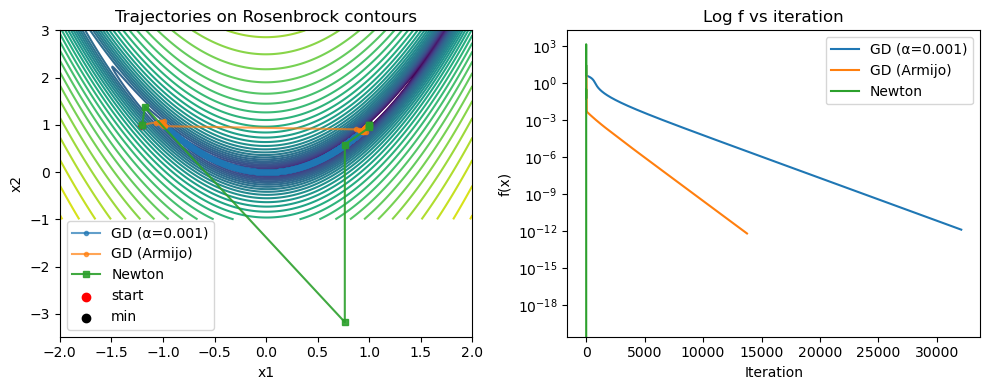

In [11]:
#question 12
import numpy as np
import matplotlib.pyplot as plt
import math, time
from matplotlib.colors import LogNorm

def f(x):
    x1, x2 = x[0], x[1]
    return 100.0*(x2 - x1**2)**2 + (1.0 - x1)**2

def grad(x):
    x1, x2 = x[0], x[1]
    g1 = -400.0*x1*(x2 - x1**2) - 2.0*(1.0 - x1)
    g2 = 200.0*(x2 - x1**2)
    return np.array([g1, g2], dtype=float)

def hess(x):
    x1, x2 = x[0], x[1]
    h11 = 1200.0*x1**2 - 400.0*x2 + 2.0
    h12 = -400.0*x1
    h22 = 200.0
    return np.array([[h11, h12],[h12, h22]], dtype=float)

# armijo-line search
def backtracking_armijo(x, p, f, grad, alpha0=1.0, rho=0.5, c=1e-4, max_iters=50):
    g = grad(x)
    gTp = g.dot(p)
    if gTp >= 0:
        return 1e-8
    alpha = alpha0
    fx = f(x)
    for _ in range(max_iters):
        if f(x + alpha*p) <= fx + c*alpha*gTp:
            return alpha
        alpha *= rho
    return alpha

# GD
def gradient_descent(x0, alpha=0.001, max_iter=5000, tol=1e-6, use_backtracking=False):
    x = x0.copy().astype(float)
    hist = []
    t0 = time.time()
    for k in range(max_iter):
        g = grad(x)
        normg = np.linalg.norm(g)
        hist.append((k, x.copy(), f(x), normg))
        if normg < tol:
            break
        p = -g
        if use_backtracking:
            a = backtracking_armijo(x, p, f, grad, alpha0=1.0)
        else:
            a = alpha
        x = x + a * p
    t1 = time.time()
    return {'x': x, 'f': f(x), 'hist': hist, 'time': t1-t0}

# NT
def newton_method(x0, max_iter=50, tol=1e-6):
    x = x0.copy().astype(float)
    hist = []
    t0 = time.time()
    for k in range(max_iter):
        g = grad(x)
        H = hess(x)
        normg = np.linalg.norm(g)
        hist.append((k, x.copy(), f(x), normg))
        if normg < tol:
            break
        # Solve H p = -g
        try:
            p = np.linalg.solve(H, -g)
        except np.linalg.LinAlgError:
            # fallback: add small dampening to Hessian
            reg = 1e-6
            p = np.linalg.solve(H + reg*np.eye(2), -g)
        x = x + 1.0 * p  # full step
    t1 = time.time()
    return {'x': x, 'f': f(x), 'hist': hist, 'time': t1-t0}

# ---------- Run experiments from x0 = [-1.2, 1] ----------
if __name__ == "__main__":
    x0 = np.array([-1.2, 1.0])
    print("Starting point:", x0)

    # (1) Gradient descent, fixed alpha
    res_gd = gradient_descent(x0, alpha=0.001, max_iter=50000, tol=1e-6, use_backtracking=False)
    print("GD finished: iter =", len(res_gd['hist']), "f =", res_gd['f'], "time(s)=", res_gd['time'])

    # (optionally) GD with backtracking:
    res_gd_bt = gradient_descent(x0, alpha=0.001, max_iter=50000, tol=1e-6, use_backtracking=True)
    print("GD (Armijo) finished: iter =", len(res_gd_bt['hist']), "f =", res_gd_bt['f'], "time(s)=", res_gd_bt['time'])

    # (2) Newton (pure)
    res_newton = newton_method(x0, max_iter=50, tol=1e-12)
    print("Newton finished: iter =", len(res_newton['hist']), "f =", res_newton['f'], "time(s)=", res_newton['time'])

    # ---------- Plotting ----------
    # Contour grid
    xs = np.linspace(-2.0, 2.0, 400)
    ys = np.linspace(-1.0, 3.0, 400)
    X, Y = np.meshgrid(xs, ys)
    Z = (1 - X)**2 + 100*(Y - X**2)**2

    # Trajectories
    traj_gd = np.array([h[1] for h in res_gd['hist']])
    traj_gd_bt = np.array([h[1] for h in res_gd_bt['hist']])
    traj_newton = np.array([h[1] for h in res_newton['hist']])

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    levels = np.logspace(-0.5, 3.5, 35)
    plt.contour(X, Y, Z, levels=levels, norm=LogNorm(), cmap='viridis')
    if traj_gd.size:
        plt.plot(traj_gd[:,0], traj_gd[:,1], '-o', ms=3, label='GD (α=0.001)', alpha=0.7)
    if traj_gd_bt.size:
        plt.plot(traj_gd_bt[:,0], traj_gd_bt[:,1], '-o', ms=3, label='GD (Armijo)', alpha=0.7)
    if traj_newton.size:
        plt.plot(traj_newton[:,0], traj_newton[:,1], '-s', ms=4, label='Newton', alpha=0.9)
    plt.scatter([x0[0]],[x0[1]], c='red', label='start')
    plt.scatter([1.0],[1.0], c='black', label='min')
    plt.legend(); plt.title("Trajectories on Rosenbrock contours"); plt.xlabel('x1'); plt.ylabel('x2')

    # Log f vs iteration
    plt.subplot(1,2,2)
    iters_gd = [h[0] for h in res_gd['hist']]
    fvals_gd = [h[2] for h in res_gd['hist']]
    plt.plot(iters_gd, fvals_gd, label='GD (α=0.001)')
    iters_gd_bt = [h[0] for h in res_gd_bt['hist']]
    fvals_gd_bt = [h[2] for h in res_gd_bt['hist']]
    plt.plot(iters_gd_bt, fvals_gd_bt, label='GD (Armijo)')
    iters_newt = [h[0] for h in res_newton['hist']]
    fvals_newt = [h[2] for h in res_newton['hist']]
    plt.plot(iters_newt, fvals_newt, label='Newton')
    plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('f(x)'); plt.title('Log f vs iteration'); plt.legend()
    plt.tight_layout()
    plt.show()


In [13]:
# question 13
# newton_lagrange.py
import numpy as np

def F_and_J(w):
    x, y, lam = w[0], w[1], w[2]
    r = x*x + y*y
    s = np.exp(r)
    # Residual
    F = np.array([2*x*s + lam,
                  2*y*s + lam,
                  x + y - 1.0], dtype=float)
    # Jacobian
    J = np.array([
        [2*s*(1.0 + 2.0*x*x), 4.0*x*y*s, 1.0],
        [4.0*x*y*s, 2*s*(1.0 + 2.0*y*y), 1.0],
        [1.0, 1.0, 0.0]
    ], dtype=float)
    return F, J

def newton_solver(w0, tol=1e-12, maxit=50, verbose=True):
    w = w0.astype(float).copy()
    for k in range(maxit):
        F, J = F_and_J(w)
        normF = np.linalg.norm(F)
        if verbose:
            print(f"iter {k:2d}: w = {w}, ||F|| = {normF:.3e}")
        if normF < tol:
            break
        # Solve J delta = F  -> delta = J^-1 F
        # Use linear solve J * delta = F, then w <- w - delta
        # If J is nearly singular, add tiny regularizer
        try:
            delta = np.linalg.solve(J, F)
        except np.linalg.LinAlgError:
            delta = np.linalg.solve(J + 1e-12*np.eye(3), F)
        w = w - delta
    return w

if __name__ == "__main__":
    w0 = np.array([0.0, 0.0, 0.0])
    w_sol = newton_solver(w0, tol=1e-14, maxit=20, verbose=True)
    print("Newton converged to:", w_sol)
    # Compare with analytic solution:
    x_star = 0.5
    lam_star = -np.exp(0.5)
    print("Analytic:", x_star, x_star, lam_star)


iter  0: w = [0. 0. 0.], ||F|| = 1.000e+00
iter  1: w = [ 0.5  0.5 -1. ], ||F|| = 9.174e-01
iter  2: w = [ 0.5         0.5        -1.64872127], ||F|| = 0.000e+00
Newton converged to: [ 0.5         0.5        -1.64872127]
Analytic: 0.5 0.5 -1.6487212707001282


Running GD + Backtracking (Armijo)...
Running AdaGrad GD...


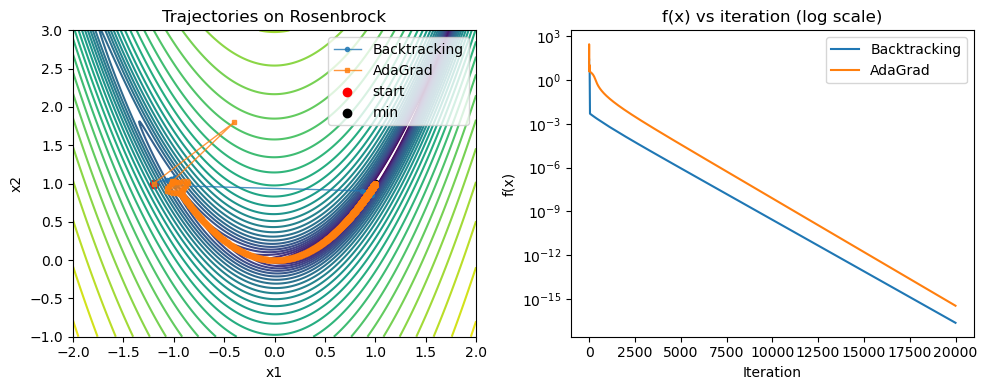

Backtracking: iterations = 20000 final f = 2.4433076567382246e-17 time(s)= 1.2176347999993595
AdaGrad:     iterations = 20000 final f = 3.5865734421657585e-16 time(s)= 0.43054380000103265
Results and plots saved in folder: gd_rosen_results


In [15]:
# question 14


import numpy as np, math, time, os
import matplotlib.pyplot as plt
import pandas as pd

# ---------- Rosenbrock ----------
def rosen(x):
    a = 1.0; b = 100.0
    return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

def grad_rosen(x):
    a = 1.0; b = 100.0
    dx = -2*(a - x[0]) - 4*b*x[0]*(x[1] - x[0]**2)
    dy = 2*b*(x[1] - x[0]**2)
    return np.array([dx, dy], dtype=float)

# ---------- Backtracking Armijo ----------
def backtracking_armijo(f, gradf, x, p, alpha0=1.0, rho=0.5, c=1e-4, max_iters=50):
    """Return alpha satisfying Armijo along direction p."""
    g = gradf(x)
    gTp = np.dot(g, p)
    if gTp >= 0:
        # not a descent direction: return tiny step
        return 1e-12
    alpha = alpha0
    fx = f(x)
    for _ in range(max_iters):
        if f(x + alpha * p) <= fx + c * alpha * gTp:
            return alpha
        alpha *= rho
    return alpha

# ---------- AdaGrad update ----------
def adagrad_update(x, grad, G_accum, lr=0.5, eps=1e-8):
    """Return new x and updated accumulator G_accum."""
    G_accum += grad**2
    step = (lr / (np.sqrt(G_accum) + eps)) * grad
    return x - step, G_accum

# ---------- GD runners ----------
def gd_backtracking(x0, f, gradf, max_iters=20000, tol=1e-8):
    x = x0.astype(float).copy()
    hist = []
    t0 = time.perf_counter()
    for k in range(max_iters):
        g = gradf(x); ng = np.linalg.norm(g)
        hist.append((k, x.copy(), f(x), ng))
        if ng < tol: break
        p = -g
        alpha = backtracking_armijo(f, gradf, x, p, alpha0=1.0, rho=0.5, c=1e-4)
        x = x + alpha * p
    t1 = time.perf_counter()
    return {"x": x, "f": f(x), "hist": hist, "time": t1-t0}

def gd_adagrad(x0, f, gradf, lr=0.8, max_iters=20000, tol=1e-8):
    x = x0.astype(float).copy()
    G = np.zeros_like(x)
    hist = []
    t0 = time.perf_counter()
    for k in range(max_iters):
        g = gradf(x); ng = np.linalg.norm(g)
        hist.append((k, x.copy(), f(x), ng))
        if ng < tol: break
        x, G = adagrad_update(x, g, G, lr=lr, eps=1e-8)
    t1 = time.perf_counter()
    return {"x": x, "f": f(x), "hist": hist, "time": t1-t0}

# ---------- Run experiment ----------
def run_and_plot():
    x0 = np.array([-1.2, 1.0])
    out_dir = "gd_rosen_results"
    os.makedirs(out_dir, exist_ok=True)

    print("Running GD + Backtracking (Armijo)...")
    res_bt = gd_backtracking(x0, rosen, grad_rosen, max_iters=20000, tol=1e-10)
    print("Running AdaGrad GD...")
    res_ag = gd_adagrad(x0, rosen, grad_rosen, lr=0.8, max_iters=20000, tol=1e-10)

    # Extract histories
    hist_bt = np.array(res_bt["hist"], dtype=object)
    hist_ag = np.array(res_ag["hist"], dtype=object)
    traj_bt = np.vstack([h[1] for h in hist_bt])
    traj_ag = np.vstack([h[1] for h in hist_ag])
    fvals_bt = np.array([h[2] for h in hist_bt])
    fvals_ag = np.array([h[2] for h in hist_ag])

    # Save CSV histories
    pd.DataFrame({
        "iter": [int(h[0]) for h in hist_bt],
        "x": [float(h[1][0]) for h in hist_bt],
        "y": [float(h[1][1]) for h in hist_bt],
        "f": [float(h[2]) for h in hist_bt]
    }).to_csv(f"{out_dir}/backtracking_history.csv", index=False)

    pd.DataFrame({
        "iter": [int(h[0]) for h in hist_ag],
        "x": [float(h[1][0]) for h in hist_ag],
        "y": [float(h[1][1]) for h in hist_ag],
        "f": [float(h[2]) for h in hist_ag]
    }).to_csv(f"{out_dir}/adagrad_history.csv", index=False)

    # Contour plot + trajectories
    xs = np.linspace(-2, 2, 400); ys = np.linspace(-1, 3, 400)
    X, Y = np.meshgrid(xs, ys)
    Z = (1 - X)**2 + 100*(Y - X**2)**2

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    levels = np.logspace(-0.5, 3.5, 30)
    plt.contour(X, Y, Z, levels=levels, norm=LogNorm(), cmap='viridis')
    plt.plot(traj_bt[:,0], traj_bt[:,1], '-o', ms=3, lw=1, label='Backtracking', alpha=0.8)
    plt.plot(traj_ag[:,0], traj_ag[:,1], '-s', ms=3, lw=1, label='AdaGrad', alpha=0.8)
    plt.scatter([x0[0]],[x0[1]], c='red', label='start')
    plt.scatter([1.0],[1.0], c='black', label='min')
    plt.legend(); plt.title('Trajectories on Rosenbrock'); plt.xlabel('x1'); plt.ylabel('x2')

    # f vs iter log-plot
    plt.subplot(1,2,2)
    plt.plot([h[0] for h in hist_bt], fvals_bt, label='Backtracking')
    plt.plot([h[0] for h in hist_ag], fvals_ag, label='AdaGrad')
    plt.yscale('log'); plt.xlabel('Iteration'); plt.ylabel('f(x)'); plt.title('f(x) vs iteration (log scale)')
    plt.legend(); plt.tight_layout()
    plt.savefig(f"{out_dir}/rosen_comparison.png", dpi=200)
    plt.show()

    # print brief numeric summary
    print("Backtracking: iterations =", len(hist_bt), "final f =", res_bt['f'], "time(s)=", res_bt['time'])
    print("AdaGrad:     iterations =", len(hist_ag), "final f =", res_ag['f'], "time(s)=", res_ag['time'])
    print("Results and plots saved in folder:", out_dir)

if __name__ == "__main__":
    run_and_plot()
